## Wavelet processing with AWI 2-18 GHz SnowRadar
Example of using the wavelet process with AWI data. Note that a child class of the snowradar class is used because  
of differneces in the way the AWI data is structured vs the OIB inputs. The range resolution is quite a bit higher due  
to the larger bandwidth over the 2-8 GHz legacy SnowRadar.

Note this approach is still in testing and has not been validated against in situ data.

&copy; J.King 2018

In [1]:
#pyWavelet modules
from pyWavelet import snowradar, picklayers

#Python stdlib
import os
import datetime
import time

#Community packages
import numpy as np
np.seterr(divide='ignore') # suppress divide-by-zero warnings in below plots
import matplotlib.pyplot as plt
import h5py
from scipy import signal

In [2]:
density_snow = 0.300 #Density of snow on sea ice; See Alexandrov et al., 2010, The Cryosphere
perm_snow = (1 + 0.51 * density_snow) ** 3  #Density to permitivity
perm_ice = 3.15
n_snow = np.sqrt(perm_snow) #Permitivity to refractive index
n_ice = np.sqrt(perm_ice)
c = 299792458 #Vacuum speed of light

In [3]:
radar_file = "./data/awi/Data_20170410_01_006.mat"
radar_dat = snowradar.AWI(radar_file, l_case='full') #Use AWI child class

Processing: C:\Users\kingj\My Documents\Projects\2018-2019\250618_Wavelet\pyWavelet\pyWavelet\data\awi\Data_20170410_01_006.mat


Estimate the pulse width

In [4]:
radar_dat.calcpulsewidth()
print("Equivalent pulse width %f" % (radar_dat.epw))
print("Null-to-null pulse width %f" % (radar_dat.n2n))

Equivalent pulse width 0.028389
Null-to-null pulse width 0.075698


## Draft surface elevation compensation

[see source code](https://github.com/kingjml/pyWavelet/blob/49f7665a969780b6f81c66709db27274754a8f15/pyWavelet/snowradar.py#L87)

This only works if the surface variable is available at source
In the future we need to write a module to produce the surface if missing

Also need to think of an alternative way to retain `elev_axis` instead of just dumping it from `elevation_compensation()`

In [5]:
if not radar_dat.elev_corrected: #Check if its corrected
    radar_dat.data_radar, radar_dat.elev_axis = radar_dat.elevation_compensation() # Compensate for aircraft atitude
    radar_dat.surf_bin, x = radar_dat.get_surface() # Retrack the surface
    radar_dat.elev_corrected = True

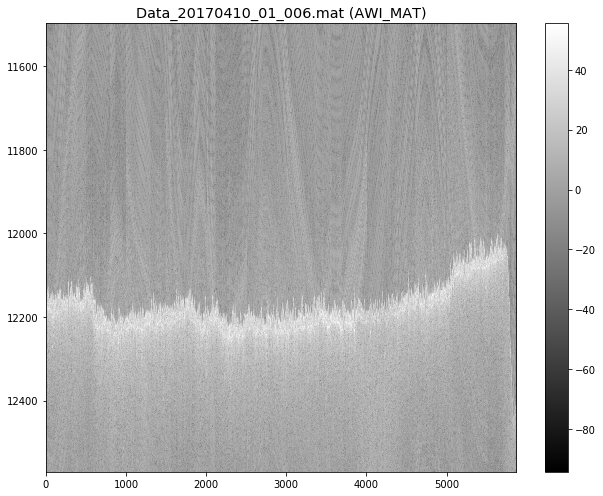

In [6]:
radar_dat.plot_quicklook(ylim = list(radar_dat.get_bounds(5)))

The current AWI data is unfiltered so we apply a boxcar window to knock down the noise a bit  
Window length is arbitrary but maintain a short scale to avoid smoothing actual variability

In [7]:
def RadarWindow(x,window_len=11):
    return np.convolve(
        signal.windows.boxcar(window_len) / signal.windows.boxcar(window_len).sum(),
        x,
        mode='valid'
    )

In [8]:
data_bound = radar_dat.get_bounds(5)
radar_sub = radar_dat.data_radar[data_bound[1]:data_bound[0],0:300]
#radar_sub = radar_dat.data_radar[valid_idx,0:300]
radar_1d_smooth = np.apply_along_axis(RadarWindow, 0, radar_sub, 5)
radar_2d_smooth = signal.medfilt2d(radar_sub, kernel_size=5)

A-Scope example of the raw and smoothed radar traces

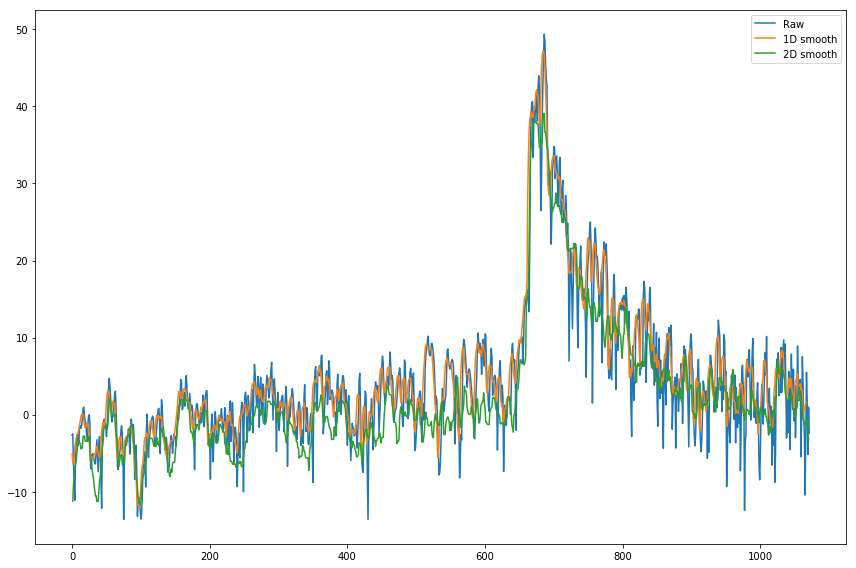

In [9]:
col_idx = 150
fig, ax = plt.subplots(figsize=(12,8))
#ax.plot(data_col)
ax.plot(10*np.log10(radar_sub[:,1]))
ax.plot(10*np.log10(radar_1d_smooth[:,1]))
ax.plot(10*np.log10(radar_2d_smooth[:,1]))
ax.legend(('Raw', '1D smooth', '2D smooth'))
fig.tight_layout();

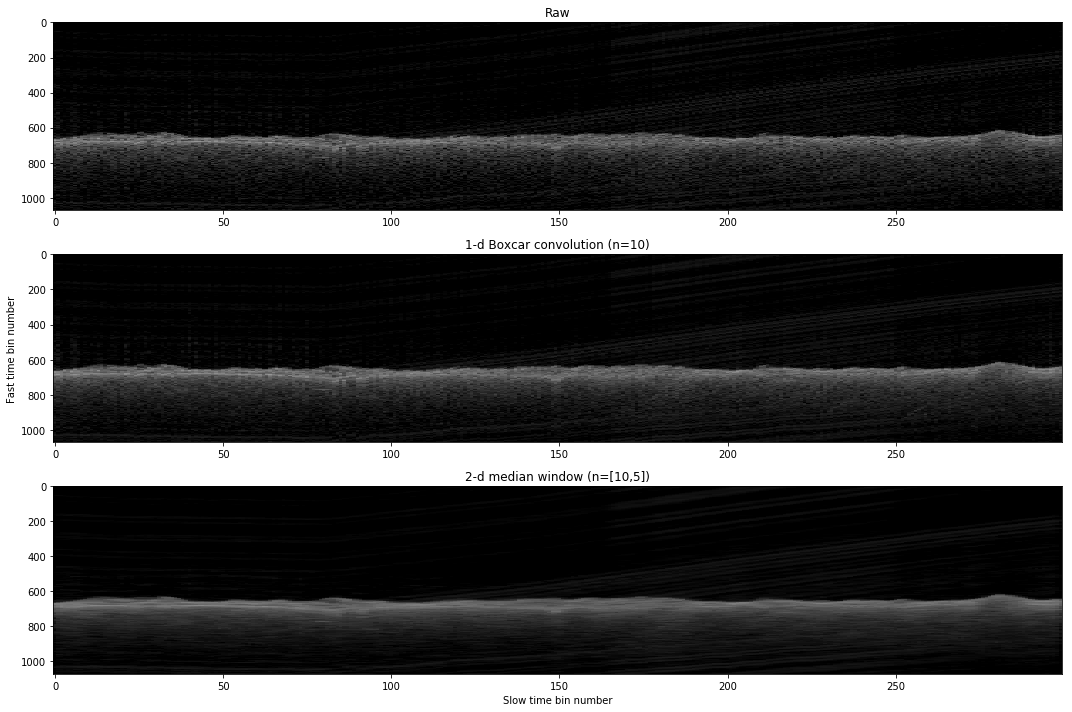

In [10]:
vis_max = 80
vis_min = 0

fig, ax = plt.subplots(3,1,figsize=(15,10))
ax[0].set_title("Raw")
ax[0].imshow(10 * np.log10(radar_sub), interpolation='nearest', cmap="gist_gray", vmin=vis_min, vmax=vis_max)
ax[0].set_aspect('auto')
#ax[0].set_ylim([ymax, ymin])
ax[1].set_ylabel("Fast time bin number")
ax[1].set_title("1-d Boxcar convolution (n=10)")
ax[1].imshow(10 * np.log10(radar_1d_smooth), interpolation='nearest', cmap="gist_gray", vmin=vis_min, vmax=vis_max)
ax[1].set_aspect('auto')
#ax[1].set_ylim([ymax, ymin])
ax[2].set_title("2-d median window (n=[10,5])")
ax[2].imshow(10 * np.log10(radar_2d_smooth), interpolation='nearest', cmap="gist_gray", vmin=vis_min, vmax=vis_max)
ax[2].set_aspect('auto')
#ax[2].set_ylim([ymax, ymin])
ax[2].set_xlabel("Slow time bin number")
fig.tight_layout();

Apply the wavelet picker to each radar trace to identify the air-snow and snow-ice interfaces   
Numpy applies a serial process (slow)  
In the future this makes sense to distribute over N cores

Then calculate the snow depth using an assumption of the refractive index 
The air-snow picks seem to perform well but there is a lot of noise in the snow-ice interface  
Note the standard deviation of the snow depth is ~3/4 of the mean depth. This worries me a bit but not knowing the environment I can't draw a conclusion.   
The result of much more reasonable when averaged over 5 or more bins.  

In [11]:
%time l_as, l_si = np.apply_along_axis(picklayers.picklayers, 0, radar_sub, radar_dat.n2n, radar_dat.dfr, n_snow)

Wall time: 14.4 s


In [37]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [43]:
N = 5
si_rolling_min = np.min(rolling_window(l_si, N), -1)
si_rolling_max = np.max(rolling_window(l_si, N), -1)
si_rolling_mean = np.mean(rolling_window(l_si, N), -1)

Max along-track resolution
Mean depth (m): 0.21463235173012352
StDev of  depth (m): 0.1470513106645019

5-bin averaged along-track 
Mean snow depth (m): 0.21610297116654748
StDev of snow depth (m): 0.11724785737698629


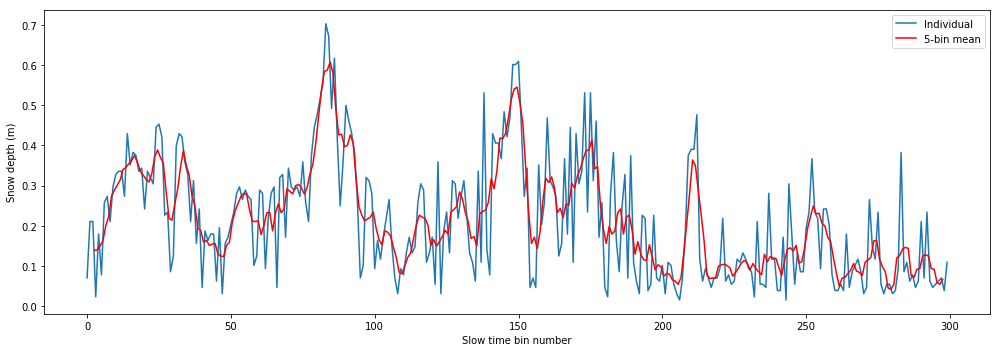

In [44]:
snow_depth = (l_si - l_as) * radar_dat.dfr / n_snow
snow_depth_smooth = np.convolve(snow_depth, np.ones((N,))/N, mode='valid')
estart = N/2
eend = len(snow_depth_rollin)+(N/2)
print("Max along-track resolution")
print("Mean depth (m):", np.mean(snow_depth))
print("StDev of  depth (m):", np.std(snow_depth))
print("\n5-bin averaged along-track ")
print("Mean snow depth (m):", np.mean(snow_depth_rollin))
print("StDev of snow depth (m):", np.std(snow_depth_rollin))

fig, ax = plt.subplots(figsize=(14,5))
ax.plot(snow_depth)
ax.plot(np.arange(estart, eend),snow_depth_rollin, color='r')

#ax.plot(l_as, color='b')
ax.set_ylabel("Snow depth (m)")
ax.set_xlabel("Slow time bin number")
ax.legend(["Individual","5-bin mean"],loc="upper right")
fig.tight_layout();

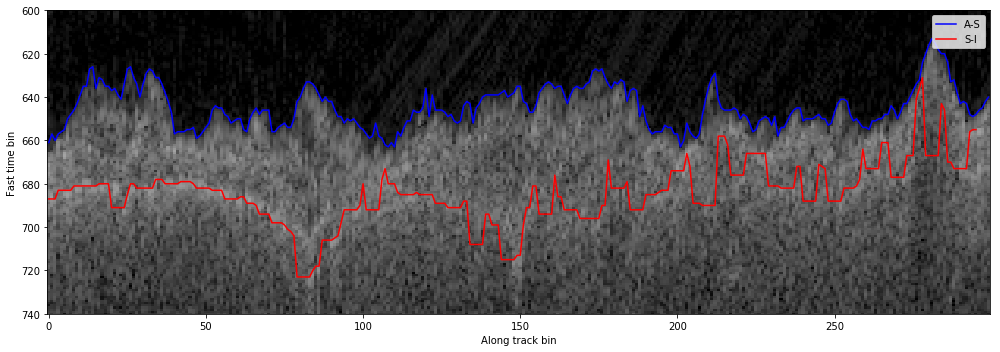

In [45]:
vis_min = -1
vis_max = 80
fig, ax = plt.subplots(figsize=(14,5))
ax.imshow(10 * np.log10(radar_sub), interpolation='none', cmap="gist_gray", vmin=vis_min, vmax=vis_max)
ax.plot(l_as, color='b')
#ax.plot(l_si, color='y')
ax.plot(si_rolling_max, color='r')
ax.set_ylabel("Fast time bin")
ax.set_xlabel("Along track bin")
ax.legend(["A-S","S-I"],loc="upper right")
ax.set_ylim([740, 600])
ax.set_aspect('auto')
fig.tight_layout();

Sanity check the interface picks.

213


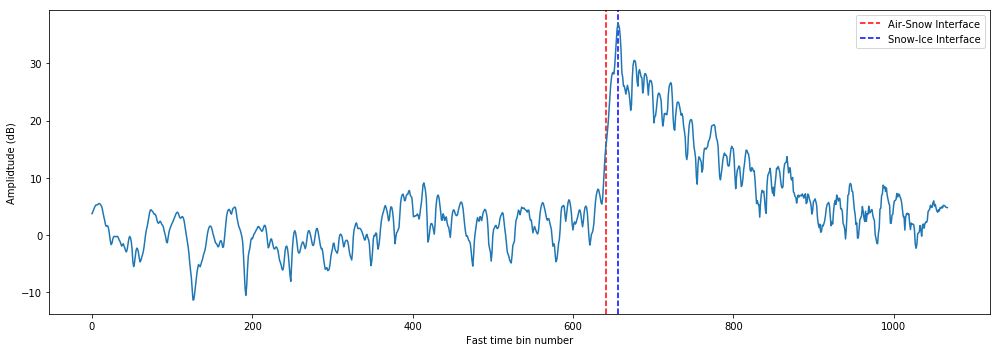

In [46]:
col_idx = np.random.randint(0, radar_1d_smooth.shape[1])
print(col_idx)
fig, ax = plt.subplots(figsize=(14,5))
#ax.plot(data_col)
ax.plot(10*np.log10(radar_1d_smooth[:,col_idx]), label=None)
# Air-Snow picked interface
ax.vlines(l_as[col_idx], 0, 1, label='Air-Snow Interface', linestyles='dashed', transform=ax.get_xaxis_transform(), color='r')
# Snow-Ice picked interface
ax.vlines(l_si[col_idx], 0, 1, label='Snow-Ice Interface', linestyles='dashed', transform=ax.get_xaxis_transform(), color='b')
ax.set_xlabel("Fast time bin number")
ax.set_ylabel("Amplidtude (dB)")
ax.legend(loc="upper right")
#ax.set_xlim([ymin, ymax])
fig.tight_layout();